In [1]:
import os
import dmd
os.environ["OMP_NUM_THREADS"]='8'
import matplotlib.pyplot as plt
import numpy as np
import timeit
from scipy.interpolate import griddata
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

### Input trajectories

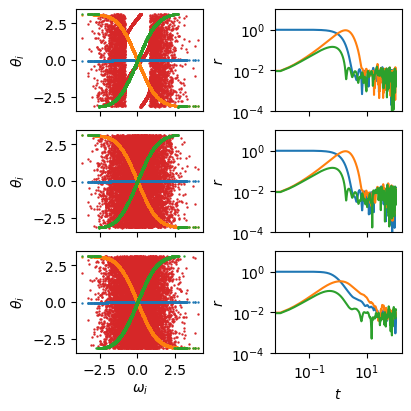

In [2]:
filebases=['data/dmd/10000/2','data/dmd2/10000/2','data/dmd/10000/10000']
fig,axs=plt.subplots(3,2,figsize=(4,4) ,constrained_layout=True)

numtraj=3

for m in range(len(filebases)):
    for n in range(numtraj):
        filebase='%s/%i'%(filebases[m],n)
        file=open(filebase+'.out')
        lines=file.readlines()
        N,K,t1,dt,c,seed=np.array(lines[0].split(),dtype=np.float64)
        N=int(N)
        K=int(K)
        file.close()

    
        omega=np.fromfile(filebase+'frequencies.dat',dtype=np.float64)
        N=len(omega)
        thetas=np.fromfile(filebase+'thetas.dat',dtype=np.float64).reshape((-1,N))
        thetas=thetas-np.mean(omega)*dt*np.arange(thetas.shape[0])[:,np.newaxis]
        orders=np.fromfile(filebase+'order.dat',dtype=np.float64)
    
        plt.subplot(3,2,2+2*m)
        plt.plot(np.arange(len(orders))*dt,orders,c=colors[n],zorder=-5)
        plt.gca().set_rasterization_zorder(0)
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel('$r$')
        plt.ylim(1E-4,1E1)
        if m<2:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel('$t$')

        
        plt.subplot(3,2,1+2*m)
        plt.scatter(omega,np.mod(thetas[0]+np.pi,2*np.pi)-np.pi,s=0.5,zorder=-5)
        plt.gca().set_rasterization_zorder(0)
        plt.ylabel(r'$\theta_i$')
        
        if m<2:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel(r'$\omega_i$')
    plt.subplot(3,2,1+2*m)
    plt.scatter(omega,np.mod(thetas[-1]+np.pi,2*np.pi)-np.pi,s=0.5,zorder=-6)        
    

# plt.savefig('oscillatordmd1.pdf',dpi=200)
plt.show()

### Mode amplitudes decay exponentially, and order parameter DMD reconstruction is good 

In [3]:
filebases=['data/dmd/10000/2/','data/dmd2/10000/2/','data/dmd/10000/10000/']

rescrit=1E-7
for D in ['1','2','3','4','5']:
    for filebase0 in filebases:
        phis=np.load('%s%sphis.npy'%(filebase0,D))
        phitildes=np.load('%s%sphitildes.npy'%(filebase0,D))
        bs=np.load('%s%sbs.npy'%(filebase0,D))
        evals=np.load('%s%sevals.npy'%(filebase0,D))
        res=np.load('%s%sres.npy'%(filebase0,D))
        lengths=np.load('%s%slengths.npy'%(filebase0,D))
        Ndict=phis.shape[0]
        inds=np.where(res<rescrit)[0]
        for n in range(numtraj):
            print(filebase0,D,n,end='\r')
            cos_reconstruct=np.real((bs[n,inds]*phitildes[inds,:N].T).dot(evals[inds,np.newaxis]**np.arange(lengths[n]-1)[np.newaxis,:])).T
            sin_reconstruct=np.real((bs[n,inds]*phitildes[inds,Ndict//2:Ndict//2+N].T).dot(evals[inds,np.newaxis]**np.arange(lengths[n]-1)[np.newaxis,:])).T
            order=np.abs(np.mean(cos_reconstruct+1j*sin_reconstruct,axis=1))
            np.save('%s%iorder_%s.npy'%(filebase0,n,D),order)

data/dmd/10000/10000/ 5 2

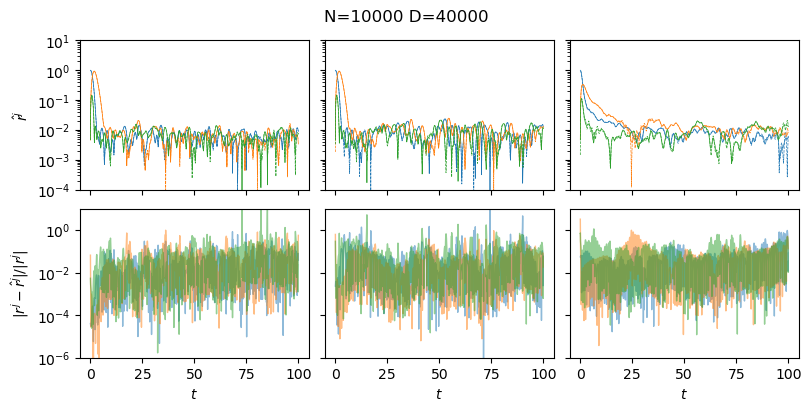

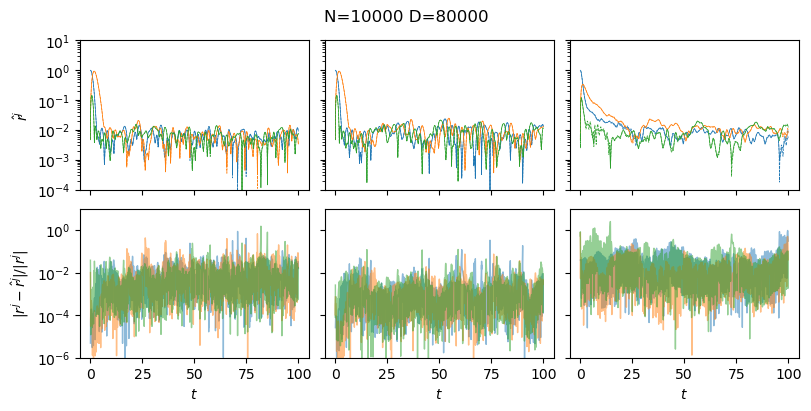

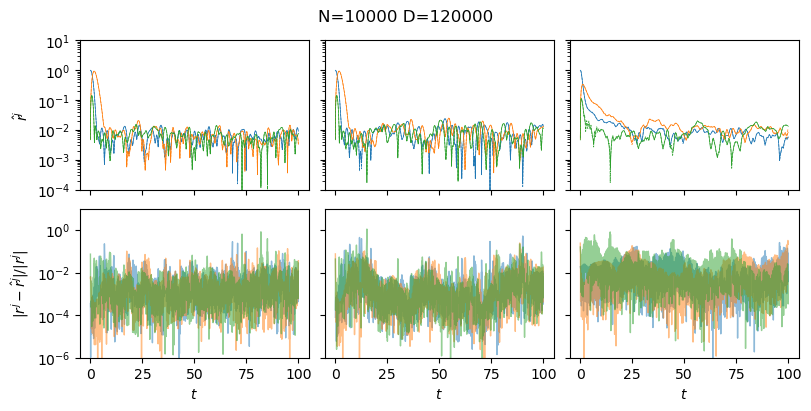

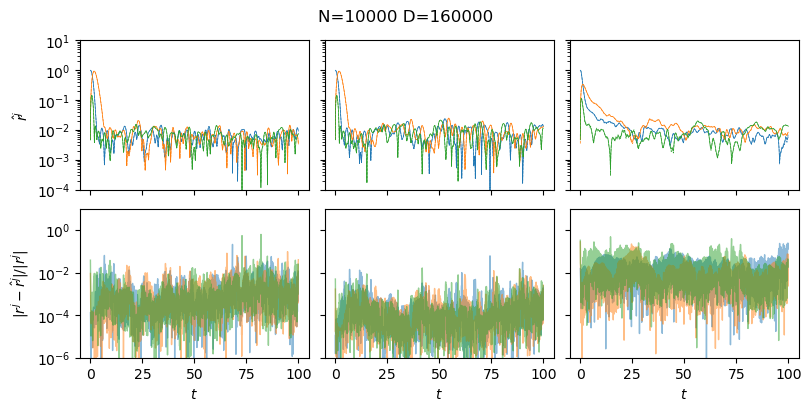

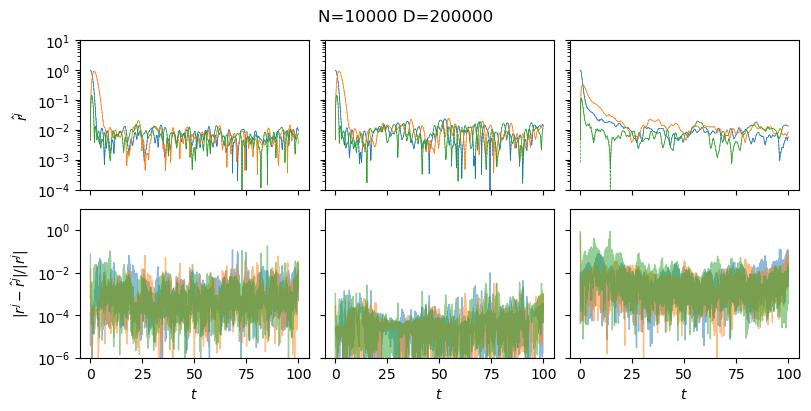

In [4]:
filebases=['data/dmd/10000/2/','data/dmd2/10000/2/','data/dmd/10000/10000/']
resmin=1E-5
resmax=1E-10
rescrit=1E-7
for D in ['1','2','3','4','5']:
    fig,axs=plt.subplots(2,3,figsize=(8,4),layout='constrained')
    M=int(D[0])
    if M==0:
        fig.suptitle('N=%i D=%i'%(N,N*2))
    else:
        fig.suptitle('N=%i D=%i'%(N,N*2*M+N/2*4*M))

    for m in range(len(filebases)):
        filebase0=filebases[m]
        bs=np.load('%s/%sbs.npy'%(filebase0,D))
        evals=np.load('%s/%sevals.npy'%(filebase0,D))
        res=np.load('%s/%sres.npy'%(filebase0,D))
        lengths=np.load('%s/%slengths.npy'%(filebase0,D))
        inds=np.where(res<rescrit)[0]
        for n in range(numtraj):
#             plt.subplot(3,3,m+1)
#             # inds2=np.argsort(np.abs(bs[n0s[n],inds]))
#             # plt.plot(np.arange(lengths[n])*dt,np.abs(bs[n,inds[inds2[:]]]),c=colors[n],lw=0.5,alpha=0.2)
#             plt.ylim(1E-3,1E-1)
#             plt.yscale('log')
#             # plt.xscale('log')
#             plt.ylim(1E-3,1E-1)
# #             plt.xlim(0,50)
#             plt.gca().set_xticklabels('')
    
#             if m==0:
#                 plt.ylabel('$b_i^j$')
#             else:
#                 plt.gca().set_yticklabels('')
#             plt.gca().set_xticklabels('')
                    
            plt.subplot(2,3,m+1)
            filebase='%s/%i'%(filebases[m],n)
            orders=np.fromfile(filebase+'order.dat',dtype=np.float64)
            rorders=np.load(filebase+'order_%s.npy'%(D))
            plt.plot(np.arange(lengths[n]-1)*dt,rorders,c=colors[n],ls='--',zorder=-5,lw=0.5)
            plt.plot(np.arange(lengths[n]-1)*dt,orders[:-1],c=colors[n],zorder=-5,lw=0.5)
            plt.gca().set_rasterization_zorder(0)
            # plt.xscale('log')
            plt.yscale('log')
            plt.ylim(1E-4,1E1)
#             plt.xlim(0,50)
            if m==0:
                plt.ylabel(r'$\hat{r}^j$')
            else:
                plt.gca().set_yticklabels('')
            plt.gca().set_xticklabels('')
                
            plt.subplot(2,3,m+4)
            err=np.abs(rorders-orders[:-1])/orders[:-1]
            plt.plot(np.arange(lengths[n]-1)*dt,err,c=colors[n],zorder=-5,lw=1,alpha=0.5)
            plt.gca().set_rasterization_zorder(0)
            # plt.xscale('log')
            plt.yscale('log')
            plt.xlabel('$t$')
            plt.ylim(1E-6,1E1)
#             plt.xlim(0,50)
            if m==0:
                plt.ylabel(r'${ | r^j-\hat{r}^j  |}/{ | r^j  |}$')
            else:
                plt.gca().set_yticklabels('')
            


                
    # plt.savefig('oscillatordmd3_%s.pdf'%D)
    plt.show()

In [5]:
ds=[]
es=[]
for D in ['1','2','3','4','5']:
    M=int(D[0])
    if M==0:
        d=N*2
    else:
        d=N*2*M+N/2*4*M
        
    for m in range(len(filebases)):
        filebase0=filebases[m]
        for n in range(numtraj):
            ds=ds+[d]
            filebase='%s/%i'%(filebases[m],n)
            orders=np.fromfile(filebase+'order.dat',dtype=np.float64)
            rorders=np.load(filebase+'order_%s.npy'%(D))
#             es=es+[np.mean(((orders[:-1]-rorders)/orders[:-1])**2)**0.5]
            es=es+[np.mean(((orders[:-1]-rorders))**2)**0.5]

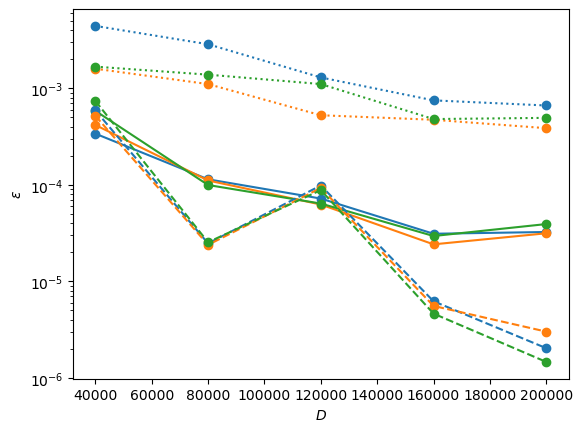

In [6]:
plt.plot(ds[::9],es[::9],marker='o',c=colors[0],ls='-')
plt.plot(ds[1::9],es[1::9],marker='o',c=colors[1],ls='-')
plt.plot(ds[2::9],es[2::9],marker='o',c=colors[2],ls='-')
plt.plot(ds[3::9],es[3::9],marker='o',c=colors[0],ls='--')
plt.plot(ds[4::9],es[4::9],marker='o',c=colors[1],ls='--')
plt.plot(ds[5::9],es[5::9],marker='o',c=colors[2],ls='--')
plt.plot(ds[6::9],es[6::9],marker='o',c=colors[0],ls=':')
plt.plot(ds[7::9],es[7::9],marker='o',c=colors[1],ls=':')
plt.plot(ds[8::9],es[8::9],marker='o',c=colors[2],ls=':')
plt.xlabel(r'$D$')
plt.ylabel(r'$\varepsilon$')
plt.yscale('log')
plt.savefig('errors.pdf')

### DMD spectrum and pseudospectrum

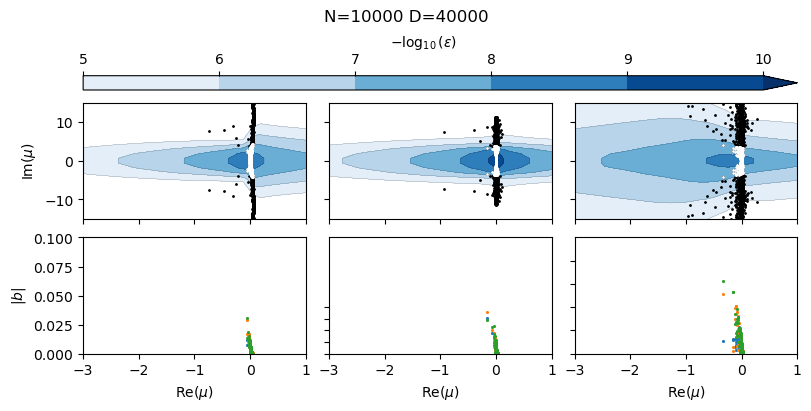

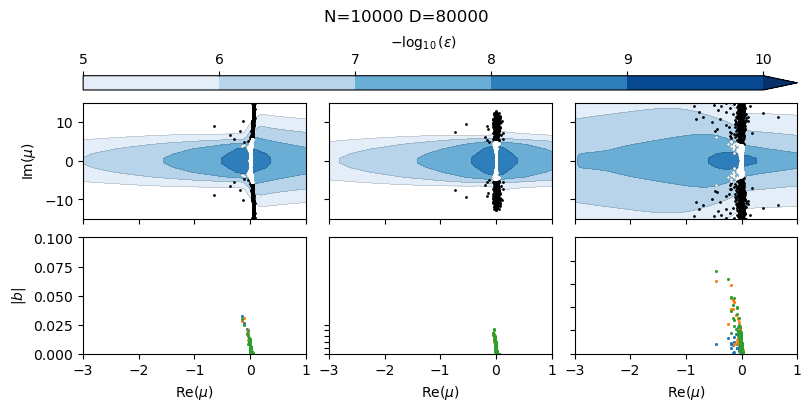

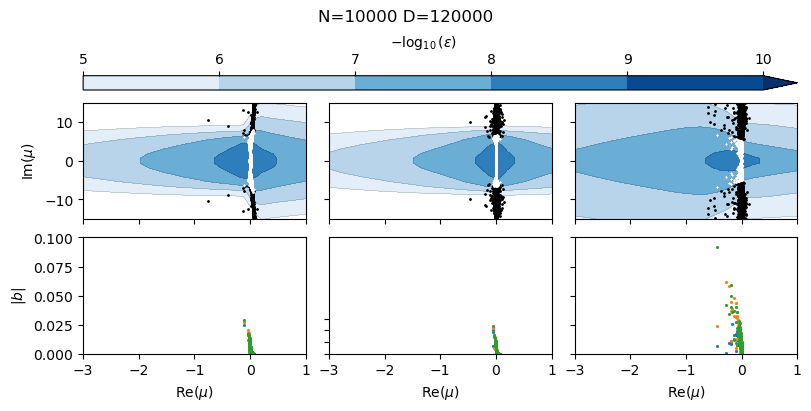

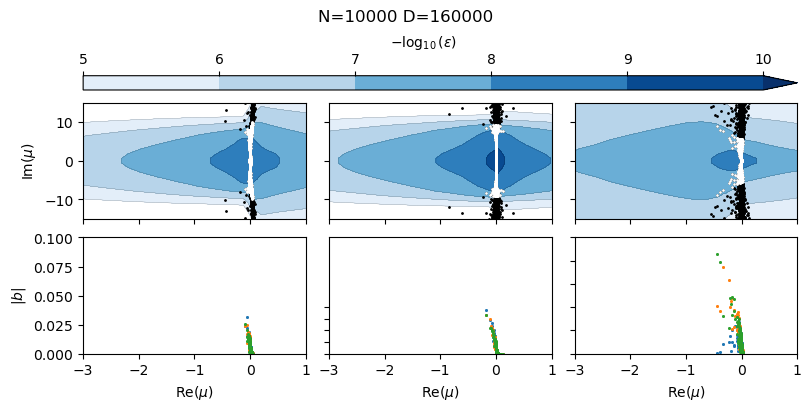

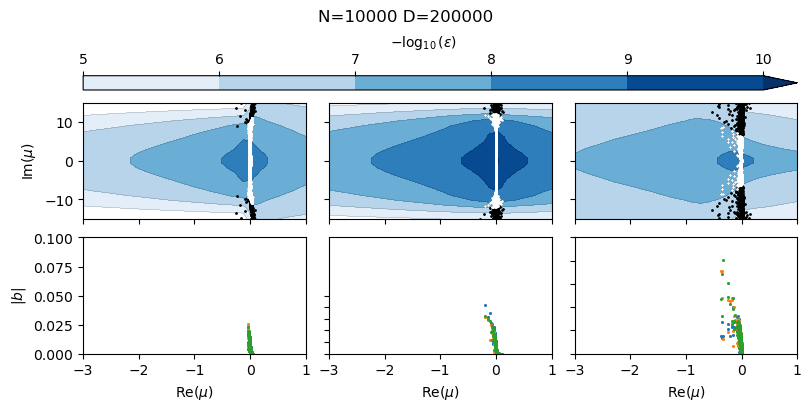

In [7]:
filebases=['data/dmd/10000/2/','data/dmd2/10000/2/','data/dmd/10000/10000/']
resmin=1E-5
resmax=1E-10
rescrit=1E-7

for D in ['1','2','3','4','5']:
    l=0
    fig,axs=plt.subplots(2,3,figsize=(8,4),layout='constrained')
    M=int(D[0])
    
    if M==0:
        fig.suptitle('N=%i D=%i'%(N,N*2))
    else:
        fig.suptitle('N=%i D=%i'%(N,N*2*M+N/2*4*M))
    numtraj=3
    for m in range(len(filebases)):
        filebase0=filebases[m]
        
        bs=np.load(filebase0+str(D)+'bs.npy')
        evals=np.load(filebase0+str(D)+'evals.npy')
        res=np.load(filebase0+str(D)+'res.npy')
        inds=np.where(res<rescrit)[0]
        xs=np.real(np.log(evals)/dt)
        
        plt.subplot(2,3,4+l)
    
        for n in range(numtraj):
            plt.scatter(xs[inds],np.abs(bs)[n,inds],c=colors[n],s=1,zorder=-5)
        plt.gca().set_rasterization_zorder(0)
    
        plt.xlabel(r'$\mathrm{Re}(\mu)$')
        plt.xlim(-3,1)
        if l>0:
            plt.gca().set_yticks(plt.gca().get_yticks(),['']*len(plt.gca().get_yticks()))
        else:
            plt.ylabel(r'$|b|$')
        plt.ylim(0,0.1)
    
        pseudo1=np.load('%s/%spseudo.npy'%(filebase0,D))
        zs1=np.load('%s/%szs.npy'%(filebase0,D))
        evals1=np.load('%s/%sevals.npy'%(filebase0,D))
        res1=np.load('%s/%sres.npy'%(filebase0,D))
        nr=26
        ni=26
        
        levels=-np.log(resmin)/np.log(10)+(-np.log(resmax)/np.log(10)+np.log(resmin)/np.log(10))*np.arange(6)/5
    
        plt.subplot(2,3,1+l)
        cs1 = plt.gca().tricontourf(np.real(np.log(zs1)/dt),np.imag(np.log(zs1)/dt),np.log(1/np.array(pseudo1))/np.log(10),levels=levels,cmap='Blues',extend='max',zorder=-5)
        cs2 = plt.gca().tricontour(cs1,levels=levels,colors=('k',),linewidths=0.1,zorder=-5)
    
        plt.gca().set_rasterization_zorder(0)
        plt.xlim(-3,1)
        plt.ylim(-15,15)
        
        xs1=np.real(np.log(evals1)/dt)
        ys1=np.imag(np.log(evals1)/dt)
    
        inds=np.where(res1<rescrit)[0]
        plt.scatter(xs1,ys1,c='black',s=1,zorder=-5)
        plt.scatter(xs1[inds],ys1[inds],c='white',s=1,zorder=-5)
        
        if l>0:
            plt.gca().set_yticklabels([])
        else:
            plt.ylabel(r'$\mathrm{Im}({\mu})$')
        plt.gca().set_xticklabels('')
    
        l=l+1
    
    fig.colorbar(cs1, ax=axs[:,:], location='top',aspect=50,label=r'$-\log_{10}(\varepsilon)$')
    
#     plt.savefig('oscillatordmd2_%s.pdf'%D,dpi=200)
    plt.show()
    

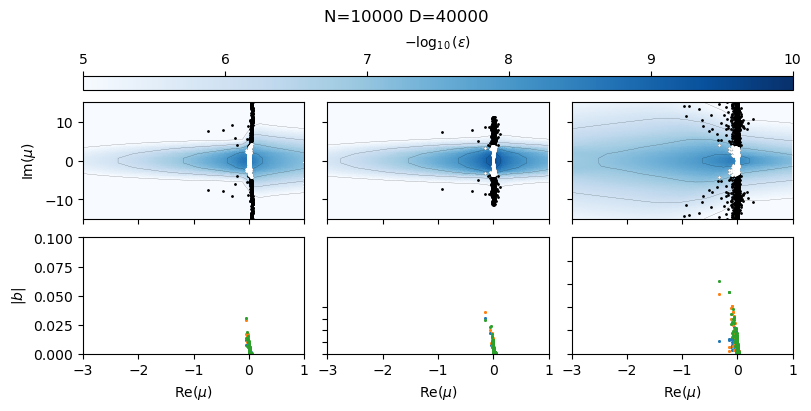

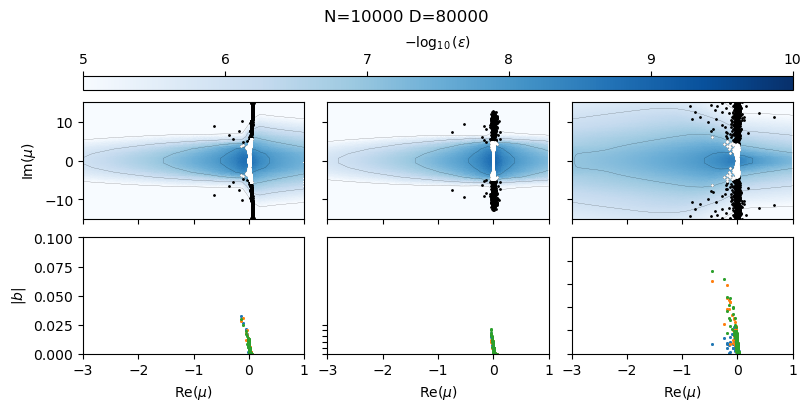

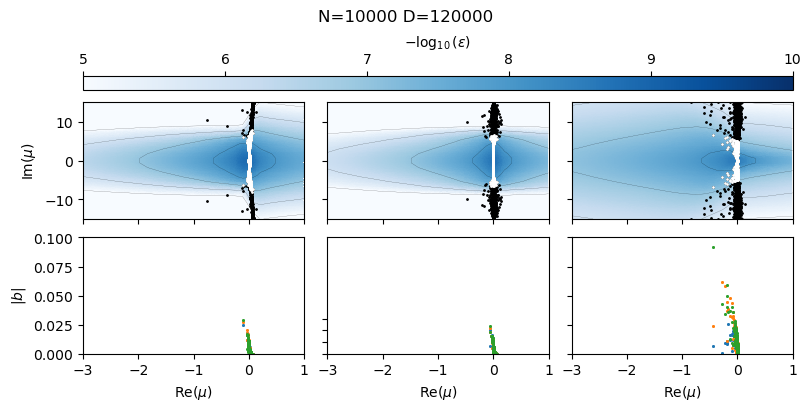

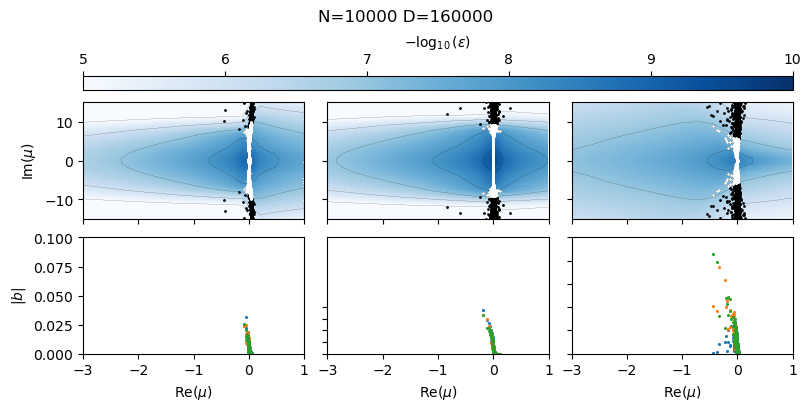

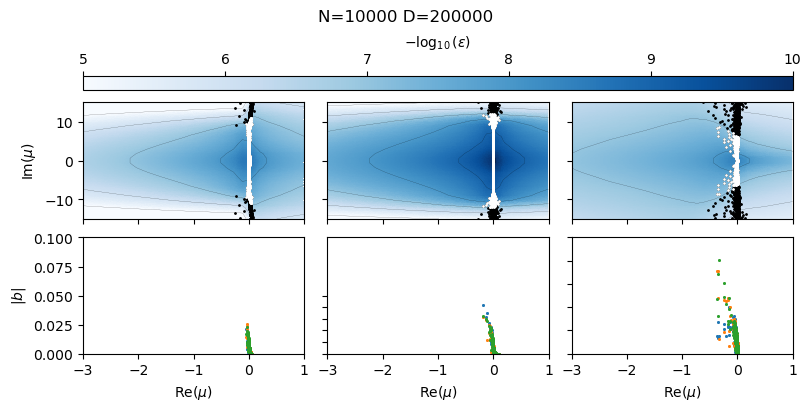

In [8]:
filebases=['data/dmd/10000/2/','data/dmd2/10000/2/','data/dmd/10000/10000/']
resmin=1E-5
resmax=1E-10
rescrit=1E-7

for D in ['1','2','3','4','5']:
    l=0
    fig,axs=plt.subplots(2,3,figsize=(8,4),layout='constrained')
    M=int(D[0])
    
    if M==0:
        fig.suptitle('N=%i D=%i'%(N,N*2))
    else:
        fig.suptitle('N=%i D=%i'%(N,N*2*M+N/2*4*M))
    numtraj=3
    for m in range(len(filebases)):
        filebase0=filebases[m]
        
        bs=np.load(filebase0+str(D)+'bs.npy')
        evals=np.load(filebase0+str(D)+'evals.npy')
        res=np.load(filebase0+str(D)+'res.npy')
        inds=np.where(res<rescrit)[0]
        xs=np.real(np.log(evals)/dt)
        pseudo1=np.load('%s/%spseudo.npy'%(filebase0,D))
        zs1=np.load('%s/%szs.npy'%(filebase0,D))

        
        plt.subplot(2,3,4+l)
    
        for n in range(numtraj):
            plt.scatter(xs[inds],np.abs(bs)[n,inds],c=colors[n],s=1,zorder=-5)
        plt.gca().set_rasterization_zorder(0)
    
        plt.xlabel(r'$\mathrm{Re}(\mu)$')
        plt.xlim(-3,1)
        if l>0:
            plt.gca().set_yticks(plt.gca().get_yticks(),['']*len(plt.gca().get_yticks()))
        else:
            plt.ylabel(r'$|b|$')
        plt.ylim(0,0.1)
    
        nr=26
        ni=26
        
        levels=-np.log(resmin)/np.log(10)+(-np.log(resmax)/np.log(10)+np.log(resmin)/np.log(10))*np.arange(6)/5
    
        plt.subplot(2,3,1+l)
        X=np.real(np.log(zs1)/dt)
        Y=np.imag(np.log(zs1)/dt)
        C=np.log(1/np.array(pseudo1))/np.log(10)

        x=-3+4*np.arange(256)/256
        y=-15+30*np.arange(256)/256
        X2,Y2=np.meshgrid(x,y)
        xi=np.array([X2,Y2]).transpose(1,2,0).reshape(-1,2)
        C2=griddata(np.array([X,Y]).T,C,xi)
        Cinds=np.where(np.isfinite(C2))[0]
        C2=C2[Cinds]
        X2=X2.ravel()[Cinds]
        Y2=Y2.ravel()[Cinds]

        cs1=plt.gca().tripcolor(X2.ravel(),Y2.ravel(),C2,cmap='Blues',zorder=-6,vmin=-np.log(resmin)/np.log(10),vmax=-np.log(resmax)/np.log(10))
        cs2 = plt.gca().tricontour(np.real(np.log(zs1)/dt),np.imag(np.log(zs1)/dt),np.log(1/np.array(pseudo1))/np.log(10),levels=levels,colors=('k',),extend='max',linewidths=0.1,zorder=-5)
    
        plt.gca().set_rasterization_zorder(0)
        plt.xlim(-3,1)
        plt.ylim(-15,15)
        
        xs1=np.real(np.log(evals)/dt)
        ys1=np.imag(np.log(evals)/dt)
    
        inds=np.where(res<rescrit)[0]
        plt.scatter(xs1,ys1,c='black',s=1,zorder=-5)
        plt.scatter(xs1[inds],ys1[inds],c='white',s=1,zorder=-5)
        
        if l>0:
            plt.gca().set_yticklabels([])
        else:
            plt.ylabel(r'$\mathrm{Im}({\mu})$')
        plt.gca().set_xticklabels('')
    
        l=l+1
    
    fig.colorbar(cs1, ax=axs[:,:], location='top',aspect=50,label=r'$-\log_{10}(\varepsilon)$')
    
#     plt.savefig('oscillatordmd2_%s.pdf'%D,dpi=200)
    plt.show()
    

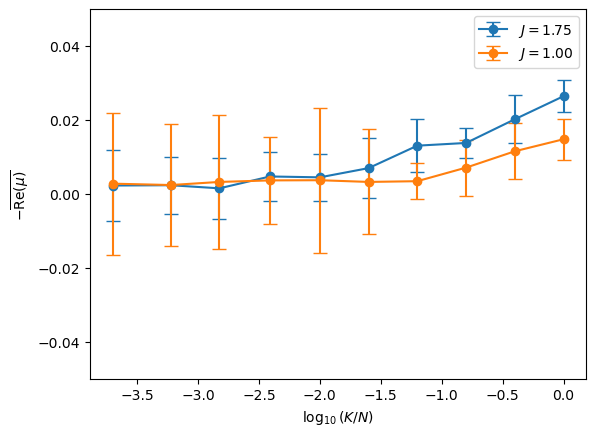

In [17]:
filebases=['data/dmd/10000/%s/'%n for n in os.listdir('data/dmd/10000')]
filebases2=['data/dmd2/10000/%s/'%n for n in os.listdir('data/dmd2/10000')]
resmin=1E-5
resmax=1E-10
rescrit=1E-7

D='5'
means=[]
stds=[]
Ks=[]
means2=[]
stds2=[]
Ks2=[]
for filebase0 in filebases:
    try:
        filebase='%s/%i'%(filebase0,0)
        file=open(filebase+'.out')
        lines=file.readlines()
        N,K,t1,dt,c,seed=np.array(lines[0].split(),dtype=np.float64)
        N=int(N)
        K=int(K)
        file.close()
        evals1=np.load('%s/%sevals.npy'%(filebase0,D))
        res1=np.load('%s/%sres.npy'%(filebase0,D))
        inds=np.where(res1<rescrit)[0]
        xs1=np.real(np.log(evals1)/dt)
        means=means+[np.mean(xs1[inds])]
        stds=stds+[np.std(xs1[inds][np.where(xs1[inds]>0)])]
        Ks=Ks+[K]
    except:
        continue
        
Ks=np.array(Ks)
means=np.array(means)
stds=np.array(stds)
order=np.argsort(Ks)

for filebase0 in filebases2:
    try:
        filebase='%s/%i'%(filebase0,0)
        file=open(filebase+'.out')
        lines=file.readlines()
        N,K,t1,dt,c,seed=np.array(lines[0].split(),dtype=np.float64)
        N=int(N)
        K=int(K)
        file.close()
        evals1=np.load('%s/%sevals.npy'%(filebase0,D))
        res1=np.load('%s/%sres.npy'%(filebase0,D))
        inds=np.where(res1<rescrit)[0]
        xs1=np.real(np.log(evals1)/dt)
        means2=means2+[np.mean(xs1[inds])]
        stds2=stds2+[np.std(xs1[inds][np.where(xs1[inds]>0)])]
        Ks2=Ks2+[K]
    except:
        continue
        
Ks2=np.array(Ks2)
means2=np.array(means2)
stds2=np.array(stds2)
order2=np.argsort(Ks2)

plt.errorbar(np.log(Ks[order]/N)/np.log(10),-means[order],yerr=stds[order],marker='o',label='$J=1.75$',capsize=5)
plt.errorbar(np.log(Ks2[order2]/N)/np.log(10),-means2[order2],yerr=stds2[order2],marker='o',label='$J=1.00$',capsize=5)
plt.ylim(-0.05,0.05)
plt.legend()
plt.xlabel(r'$\log_{10}(K/N)$')
plt.ylabel(r'$-\overline{\mathrm{Re}(\mu)}$')
plt.savefig('glassyorder.pdf')
plt.show()

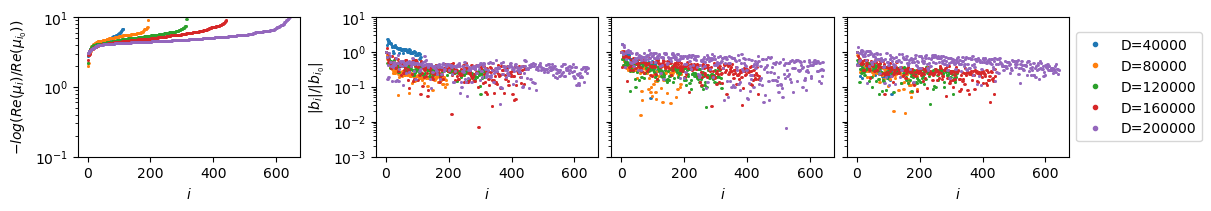

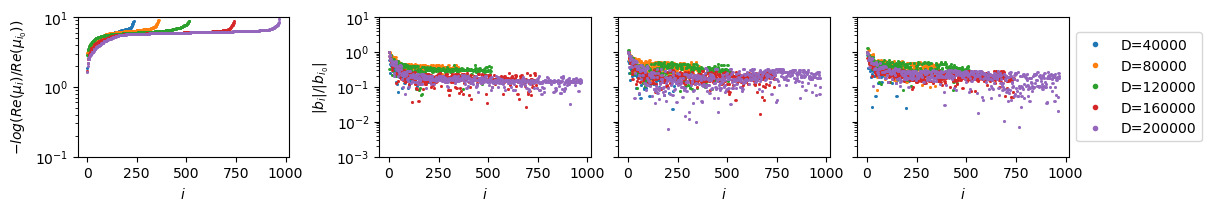

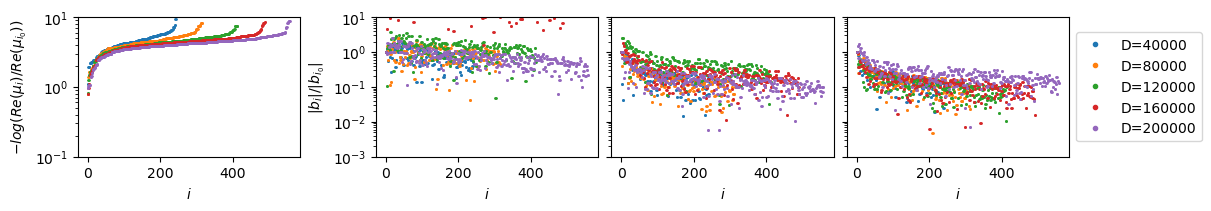

In [10]:
filebases=['data/dmd/10000/2/','data/dmd2/10000/2/','data/dmd/10000/10000/']

for filebase0 in filebases:
    resmin=1E-5
    resmax=1E-10
    rescrit=1E-7
    plt.subplots(1,4,figsize=(12,2),layout='constrained')

    for D in ['1','2','3','4','5']:
        M=int(D[0])
        bs=np.load(filebase0+str(D)+'bs.npy')
        evals=np.load(filebase0+str(D)+'evals.npy')
        res=np.load(filebase0+str(D)+'res.npy')
        inds=np.where(res<rescrit)[0]
        xs=np.real(np.log(evals[inds])/dt)

        plt.subplot(1,4,1)
        sinds=np.intersect1d(np.where(-np.sort(xs)<3)[0],np.where(np.sort(xs)<0)[0])
        vals=xs[np.argsort(xs)][sinds]
        plt.plot(-np.log(np.abs(vals)),marker='o',lw=0,ms=1)
        plt.yscale('log')
        plt.ylabel(r'$-log(Re(\mu_i)/Re(\mu_{i_0}))$')
        plt.xlabel('$i$')
        plt.ylim(1E-1,1E1)


        plt.subplot(1,4,2)
        vals=np.abs(bs[0])[inds][np.argsort(xs)][sinds]
        plt.plot(vals/vals[0],marker='o',lw=0,ms=1,label='D=%i'%(N*2*M+N/2*4*M))
        plt.yscale('log')
        plt.ylabel('$|b_i|/|b_{i_0}|$')
        plt.xlabel('$i$')
        plt.ylim(1E-3,1E1)

        plt.subplot(1,4,3)
        vals=np.abs(bs[1])[inds][np.argsort(xs)][sinds]
        plt.plot(vals/vals[0],marker='o',lw=0,ms=1,label='D=%i'%(N*2*M+N/2*4*M))
        plt.yscale('log')
        plt.xlabel('$i$')
        plt.ylim(1E-3,1E1)
        plt.gca().set_yticklabels('')

        plt.subplot(1,4,4)
        vals=np.abs(bs[2])[inds][np.argsort(xs)][sinds]
        plt.plot(vals/vals[0],marker='o',lw=0,ms=1,label='D=%i'%(N*2*M+N/2*4*M))
        plt.yscale('log')
        plt.xlabel('$i$')
        plt.ylim(1E-3,1E1)
        plt.gca().set_yticklabels('')
    plt.gca().legend(loc='center left', markerscale=3, bbox_to_anchor=(1, 0.5))
    plt.show()